<a href="https://colab.research.google.com/github/fcchung/Cats-and-Dogs-Classification/blob/main/CS6140_Image_Classification_By_Brittnee_Braun_and_Felix_Chung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The goal of the following project was to explore different image classification modelsand understand how these models work. We decided to explore and compare logistic regression and convolutional neural networks, and determine which model would create a better model to train and classify whether an image contains a cat or a dog. Prior to the start of the project, we predicted that a convolutional neural network would be the better model for this task given its ability to recognize patterns among groups of pixels across input images. As a starting point, a model would be considered acceptable if it achieves at least 80% accuracy.</p>
<p> We also explore different tools that people use in image classification such as image augmentation, resizing, and batch normalization and discover how these will affect the model.</p>
<p> In the real world, the ability to classify images has become increasingly prevalent. Many image storage services allow users to search keywords in their own image libraries to find images with certain objects, animals, or people. Security tests ask users to determine where in an image certain objects are located. Performing this comparison through the following project allows us to view a snippet of the kinds of processes these services might use to perform larger scale image classification. </p>

# Import Data

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.image as mpimg
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Download Data

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
!ls


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  51.7M      0  0:00:15  0:00:15 --:--:-- 58.3M
 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


### Remove Corrupted Files

In [ ]:
num_skipped = 0

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            # Filter out badly-encoded images 
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        
        img = cv2.imread(fpath)

        if not is_jfif or img is None or img.shape[2] != 3:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)


print("Deleted %d images" % num_skipped)

Deleted 1592 images


## Generate Dataset (Size 224, Original)

In [ ]:
image_size = (224, 224)
batch_size = 32

#load database from directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
train_ds



Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

## Data Snapshot
Dog has 1 as label <br/>
Cat has 0 as label

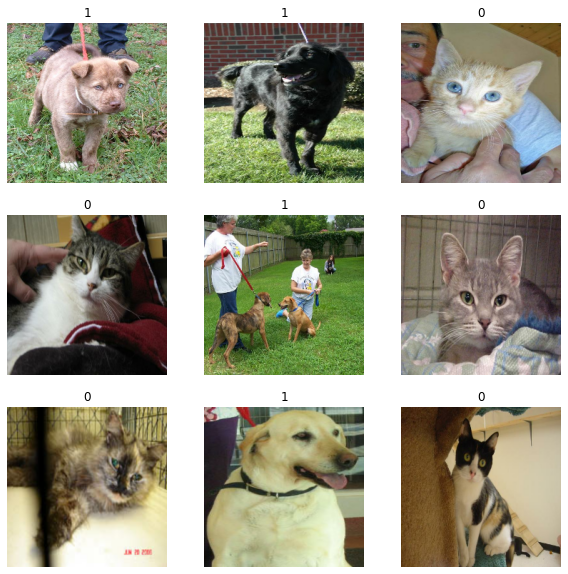

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), # randomly flip it horizontally
        layers.RandomRotation(0.1), #randomly rotate 10 degrees
    ]
)

### Augmented Data Snapshot
This will transform the image by randomly rotating or flipping the image.
This is needed because when the image is flattened, the array of pixels for a rotated image will be completely different.

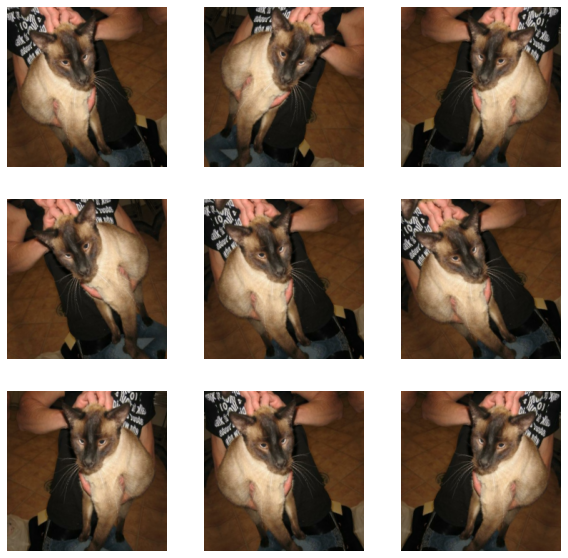

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Build Models

### Epoch

In [ ]:
epochs = 20

## Logistic Regression

The following section will use Logistic Regression to classify cats and dogs.

### Explanation
Logistic regression calculates the linear combination of the given input features. It then uses the sigmoid function to normalize the results. Finally, the binary result is simply calculated by determining whether the result of the sigmoid function is greater or less than a given threshold. Here we set the threshold to be 0.5 since an image is equally likely to be a cat or a dog. This is accomplished by rounding the result of the sigmoid function to the nearest integer.

### Why is the performance so low?

<p>Plainly, a photo is a matrix of pixels with RGB values. Logistic regression works by  flattening this 3D matrix into a single array of values and using each position in the array as a feature. This means it does not have any way to represent the relationship between pixels that are next to each other. It also cannot identify patterns using groups of pixels across images. </p>

*To write our own implementation of logistic regression, we utilized a modified version of the code from assignment 3, where we also had to implement this model.*

In [ ]:
def compute_cost(ip, op, params):
    """
    Cost function in linear regression where the cost is calculated
    ip: input variables
    op: output variables
    params: corresponding parameters
    Returns cost
    """
    num_samples = len(ip)
    total_cost = 0
    # if sigmoid function is 1 or 0, the cost function will take in log(0) which is undefined.
    # So I used something that is close to the number to represent the 1 and 0.
    for i in range(num_samples):
        sig = sigmoid(np.dot(ip[i], params))
        if sig == 1:
            sig = 0.999999
        if sig == 0:
            sig = 1e-7
        total_cost += -op[i]* np.log(sig) - (1-op[i])*np.log(1- sig)

    cost = total_cost/num_samples
    return cost

In [ ]:
def sigmoid(z):
    """
    Sigmoid function to normalize the variable between zero and one
    z: value
    Returns result of value in sigmoid function rounded to the nearest whole number
    """
    #this is to avoid overflow
    if z < 0:
        return int(round(1 - 1/(1+np.exp(z))))
    else:
        return int(round(1 / (1 + np.exp(-z))))

In [ ]:
def logistic_regression_using_batch_gradient_descent(ip, op, params, alpha, max_iter, batch_size = 1):
    """
    Compute the params for linear regression using batch gradient descent
    ip: input variables
    op: output variables
    params: corresponding parameters
    alpha: learning rate
    max_iter: maximum number of iterations
    batch_size: size of mini-batches
    Returns parameters, cost, params_store
    """ 
    # initialize iteration, number of samples, cost
    iteration = 0
    num_samples = len(ip)
    cost = np.zeros(max_iter)
    
    #batchify the data into mini-batches
    num_batch = num_samples//batch_size
    batches = []
    for i in range(num_batch):
        start = i*batch_size
        end = (i+1)*batch_size
        if i == num_batch - 1:
            end = num_samples
        x_batch = ip[start:end]
        y_batch = op[start:end]
        batches.append( (np.asarray(x_batch),np.asarray(y_batch)))
    
    
    # Compute the cost and store the params for the corresponding cost
    while iteration < max_iter:
        cost[iteration] = compute_cost(ip, op, params)    
        for x_batch,y_batch in batches:
            o = [sigmoid(np.dot(params.transpose(), x_batch[i])) for i in range(len(x_batch))]
            gradient = np.dot(x_batch.transpose(), (o - y_batch))
            params -= alpha * gradient/len(y_batch)
        iteration += 1
    
    return params, cost

In [ ]:
def evaluate(x_test, y_test,params):
    """
    Evaluate the model, return the accuracy, precision and recall
    Assumes a threshold of 0.5.
    x_test: input variables 
    y_test: labels
    params: corresponding parameters
    """ 
    preds = []
    for row in x_test:
        pred = 0
        for m in range(len(row)):
            pred += row[m,] * params[m]
        preds.append(sigmoid(pred))
    acc = accuracy_metric(y_test, preds)
    
    correct_pos = sum([1.0 for i in range(len(y_test)) if (y_test[i] >= 0.5 and preds[i] >= 0.5)])
    if correct_pos == 0:
      precision = 0
    else:
      precision = correct_pos / (correct_pos + sum(preds)) * 100.0
    recall = correct_pos /sum(y_test) * 100.0
    
    return acc,precision,recall

In [ ]:
def cross_validation(x_train_full, y_train_full, k, alpha, max_iter, batch_size):
    """
    For a given set of hyper-parameters, do k-fold cross_validation, return the average accuracy.
    x_train_full: the full training data
    y_test: the full training labels
    k: number of folds to divide the whole training set
    alpha: step-size for Gradient Descent
    max_iter: maximum number of iterations
    batch_size: size of mini-batches
    Return the average accuracy
    """
    #split the data into k-folds
    all_accs = []
    num_samples = len(x_train_full)
    fold_size = num_samples//k
    params = np.zeros(x_train_full.shape[1])
    for idx in range(k):
        ###during each iteration, we hold out one fold for evaluation, and use the rest as training data
        x_train = []
        y_train = []
        x_eval, y_eval = [],[]
        for i in range(num_samples):
            if i >= idx * fold_size and i <(idx + 1)*fold_size:
                x_eval.append(x_train_full[i])
                y_eval.append(y_train_full[i])
            else:
                x_train.append(x_train_full[i])
                y_train.append(y_train_full[i])
        #After figuring out the training and eval data, train your model and evaluate it to get the accuracy.
        params, cost = logistic_regression_using_batch_gradient_descent(x_train, y_train, params,alpha,max_iter, batch_size)
        acc, precision, recall = evaluate(x_eval, y_eval, params)
        all_accs.append(acc)
    average_acc = sum(all_accs)/k
    return average_acc

In [ ]:
alpha = 5e-4
max_iter = 100
batch_size = 32
cv_results =[]

In [ ]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [ ]:
def run_logistic_regression(data, data_labels):
  x_train, x_test, y_train, y_test = train_test_split(data, data_labels, test_size=0.20)
  x_train = np.append(x_train, np.ones((len(x_train),1)), axis=1)
  x_test = np.append(x_test, np.ones((len(x_test),1)), axis=1)
  average_acc = cross_validation(x_train, y_train, 10, alpha, max_iter,batch_size)
  cv_results.append([average_acc,alpha])
  cv_results.sort()
  best_alpha = cv_results[-1][1]

  params = np.zeros(x_train.shape[1])
  params, costs =\
      logistic_regression_using_batch_gradient_descent(x_train, y_train, params, best_alpha, max_iter, batch_size=batch_size)
  final_acc,final_precision,final_recall = evaluate(x_test, y_test,params)
  print ('Final results : Accuracy:{:.2f}, Precision:{:.2f},Recall:{:.2f}'.format(final_acc,final_precision,final_recall))
  plt.plot(costs)

### Test Size Reduced to 180

In [ ]:
data = []
data_labels = []
size = 180
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        
        img = cv2.imread(fpath)
        if not img is None and img.shape[2] == 3:   
          img = cv2.resize(img, (size, size))
          data.append(img.flatten()/255.0)
          if folder_name == "Cat":
            data_labels.append(0)
          else:
            data_labels.append(1)


Final results : Accuracy:53.80, Precision:34.02,Recall:89.82


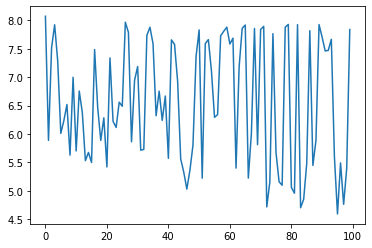

In [ ]:
run_logistic_regression(data, data_labels)

### Test Size Reduced to 90

Final results : Accuracy:61.21, Precision:39.81,Recall:44.12


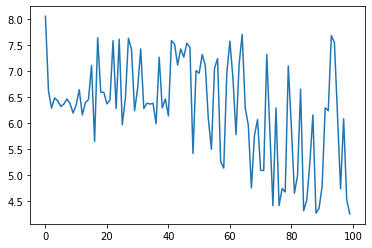

In [ ]:
data = []
data_labels = []
size = 90
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        
        img = cv2.imread(fpath)
        if not img is None and img.shape[2] == 3:   
          img = cv2.resize(img, (size, size))
          data.append(img.flatten()/255.0)
          if folder_name == "Cat":
            data_labels.append(0)
          else:
            data_labels.append(1)
run_logistic_regression(data, data_labels)

*As shown below, the CNN model was tested using three different image sizes. We attempted to show this for the Logistic Regression model, however, the size of the dataset increased too significantly for the computing power we had accessible.*

### Logistic Regression Results

Based on our initial goal of achieving an accuracy of 80%, the model based on logistic regression achieved an insufficient accuracy of 61%. Since it is unable to group pixels, or even the RGB values of one pixel, together, it has difficulty classifying the given images.

Oddly, an image size of 90x90 achieved a higher accuracy than the image size of 180x180. We would predict that providing more information for each image would increase the model's accuracy, but this was not the result. The input image size of 90x90 also had a more negative trend in cost throughout the 100 iterations of the model, as shown by the graphs above.

Note that one of the assignments for class asked us to use logistic regression to classify images, and that model did rather well. The difference between these two models is that the numerical classification models looks for the appearance of pixels of the same color values at the same spots within the flattened image array. Meanwhile, a cat or dog may appear at any location within each of these images. This randomization makes it more difficult for the model to find similarites across features. Had the images been of different cats and dogs in the same position for all images, this model would have performed much better.

## CNN Model
The following section will attempt to use a convolutional neural network to classify cats and dogs.

### CNN Explanation
<p> Unlike Logistic Regression, a Convolutional Neural Network is able to extract and identify small parts of an image to detect patterns. However, when an image is rotated or flipped, CNN will treat the image as a separate object. Therefore, we need to augment the data in the previous cell before feeding into the CNN.</p>
<p>A Convolutional Neural Network is very similar to a neural network. It is made up of neurons that contain weights and a bias and have a loss function. In our case, because we're using binary classification, we used the sigmoid function as an activation function.</p>
<p>In CNN, the image data will go through different layers, such as the convolutional layer, activation, batch normalization, and max-polling.</p>
<p>When the image is in each of the convolutional layers, each neuron will be responsible for a receptive field of a size 3 by 3 with a stride size of 2. This means that, for each image, there will be a neuron that is responsible for the size of a 3x3 pixel box, and this box can overlap in the way that the second box is 2 units next to the first box. Also, padding with "same" indicates that there is zero padding. When the box is out of range, the model will give those pixels a value of zero. </p>
<p>The max-polling layer will perform a down-sampling operation along the width and height and create a smaller image, this can help to reduce the computation. In this case, since we are classifying cats and dogs, this will not affect the infomation that is needed for the binary classification</p>

<p> ReLu, which stands for Rectified Linear United, is a popular activation function with the advantage that it does not activate all the neurons at the same time. It is more computationally efficient to compare the sigmoid and tanh function.</p>

<p>Batch normalization is the process of performing normalization for each mini-batch, according to Loff and Szegedy(2015). This process helps to reduce internal covariate shift, a phenomenon where the distribution of each layer's inputs changes during traning as the parameters of the previous layer changes.</p>

<p>


</p>

### VGG

VGG is a type of convolutional network that was created by Karen Simonyan and Andrew Zisserman from the University of Oxford in 2015. It is also known as the VGG16 because it supports 16 layers but also has a variation of 19 layers. 
This model won first and second place in the ImageNet challenge dataset in 2014. 
The model that Sumonyan and Zisserman used to win the ImageNet challenge takes an input size of 224 x 224 RGB images with the following layers:
3x3 convolutional layers with stride fixed to 1 pixel. 
Padding of 1 pixel for the 3x3 Conv layers and 2x2 Max-polling layer with stride 2. 

Here is an attempt to replicate the model that was used to win the ImageNet challenge.

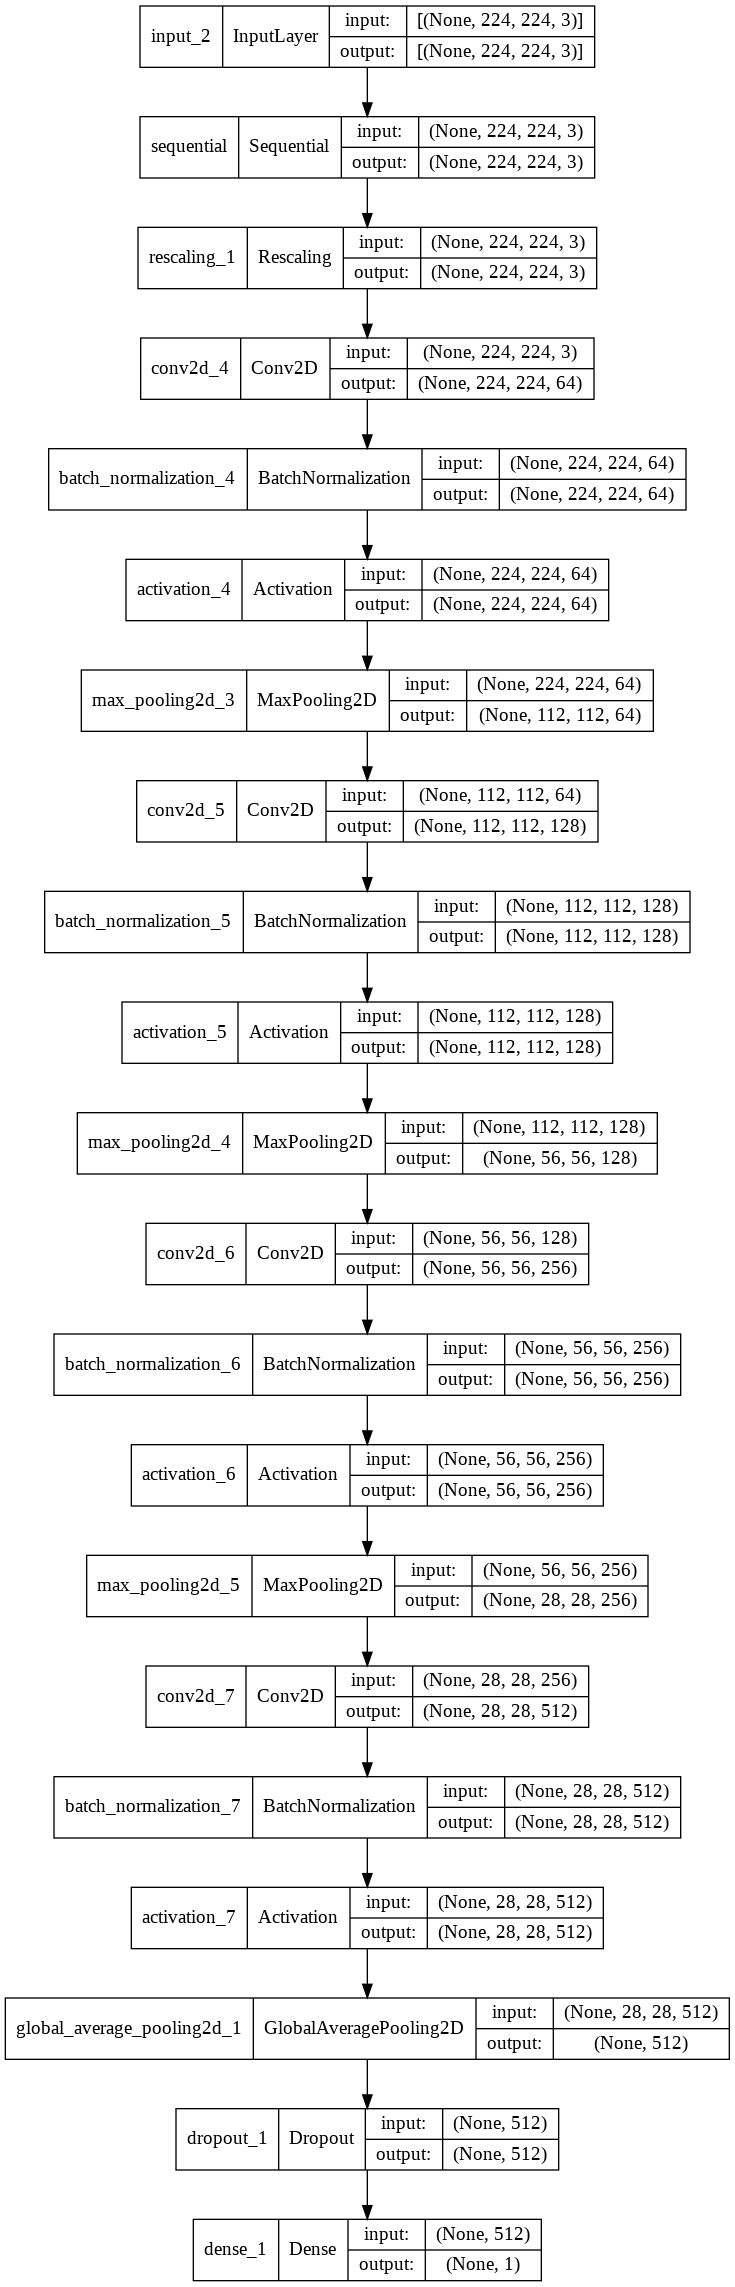

In [ ]:
def VGG_16(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  # Image augmentation block
  x = data_augmentation(inputs)
  x = layers.Rescaling(1.0 / 255)(x)
  
  #Entry block
  for size in [64, 128, 256]:
    x = layers.Conv2D(size, 3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(2, strides=2, padding="same")(x)

  x = layers.Conv2D(512, 3, strides=1, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  return keras.Model(inputs, outputs)

VGG_model = VGG_16(input_shape=image_size + (3,), num_classes=2)


keras.utils.plot_model(VGG_model, show_shapes=True)

    

In [ ]:
VGG_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_4 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 224, 224, 64)      0         
                                                           

#### VGG Result

In [ ]:
VGG_model = VGG_16(input_shape=image_size + (3,), num_classes=2)

VGG_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
VGG_model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/20
586/586 [==============================] - 22s 37ms/step - loss: 0.5778 - accuracy: 0.7025 - val_loss: 0.6521 - val_accuracy: 0.6679
Epoch 2/20
586/586 [==============================] - 22s 37ms/step - loss: 0.4517 - accuracy: 0.7878 - val_loss: 0.4102 - val_accuracy: 0.8159
Epoch 3/20
586/586 [==============================] - 22s 37ms/step - loss: 0.3953 - accuracy: 0.8201 - val_loss: 0.3789 - val_accuracy: 0.8377
Epoch 4/20
586/586 [==============================] - 22s 37ms/step - loss: 0.3520 - accuracy: 0.8446 - val_loss: 0.3287 - val_accuracy: 0.8607
Epoch 5/20
586/586 [==============================] - 22s 37ms/step - loss: 0.3333 - accuracy: 0.8535 - val_loss: 0.4440 - val_accuracy: 0.7871
Epoch 6/20
586/586 [==============================] - 22s 37ms/step - loss: 0.3050 - accuracy: 0.8680 - val_loss: 0.4533 - val_accuracy: 0.7892
Epoch 7/20
586/586 [==============================] - 22s 37ms/step - loss: 0.2842 - accuracy: 0.8788 - val_loss: 0.3019 - val_accuracy:

### Xception Model

<p>The Xception model, created by Google, is a type of convolutional neuron network that was inspired by the Inception convolutional network. It is called an extreme version of the inception model. </p>
<p> The original Xception neural network is 71 layers deep. The data first goes through the entry flow, then to the middle flow to repeat 8 times, and then to the exit flow. </p>
<p>   Because of limited computational power, the following is a simplified version of the Xception model. It does not contain the middle flow that repeats 8 times in the original model, but it implements the idea of having residual connection.</p>

In [ ]:
def CNN(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)
    
    #Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)


    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

model = CNN(input_shape=image_size + (3,), num_classes=2)



#### Model Architecture

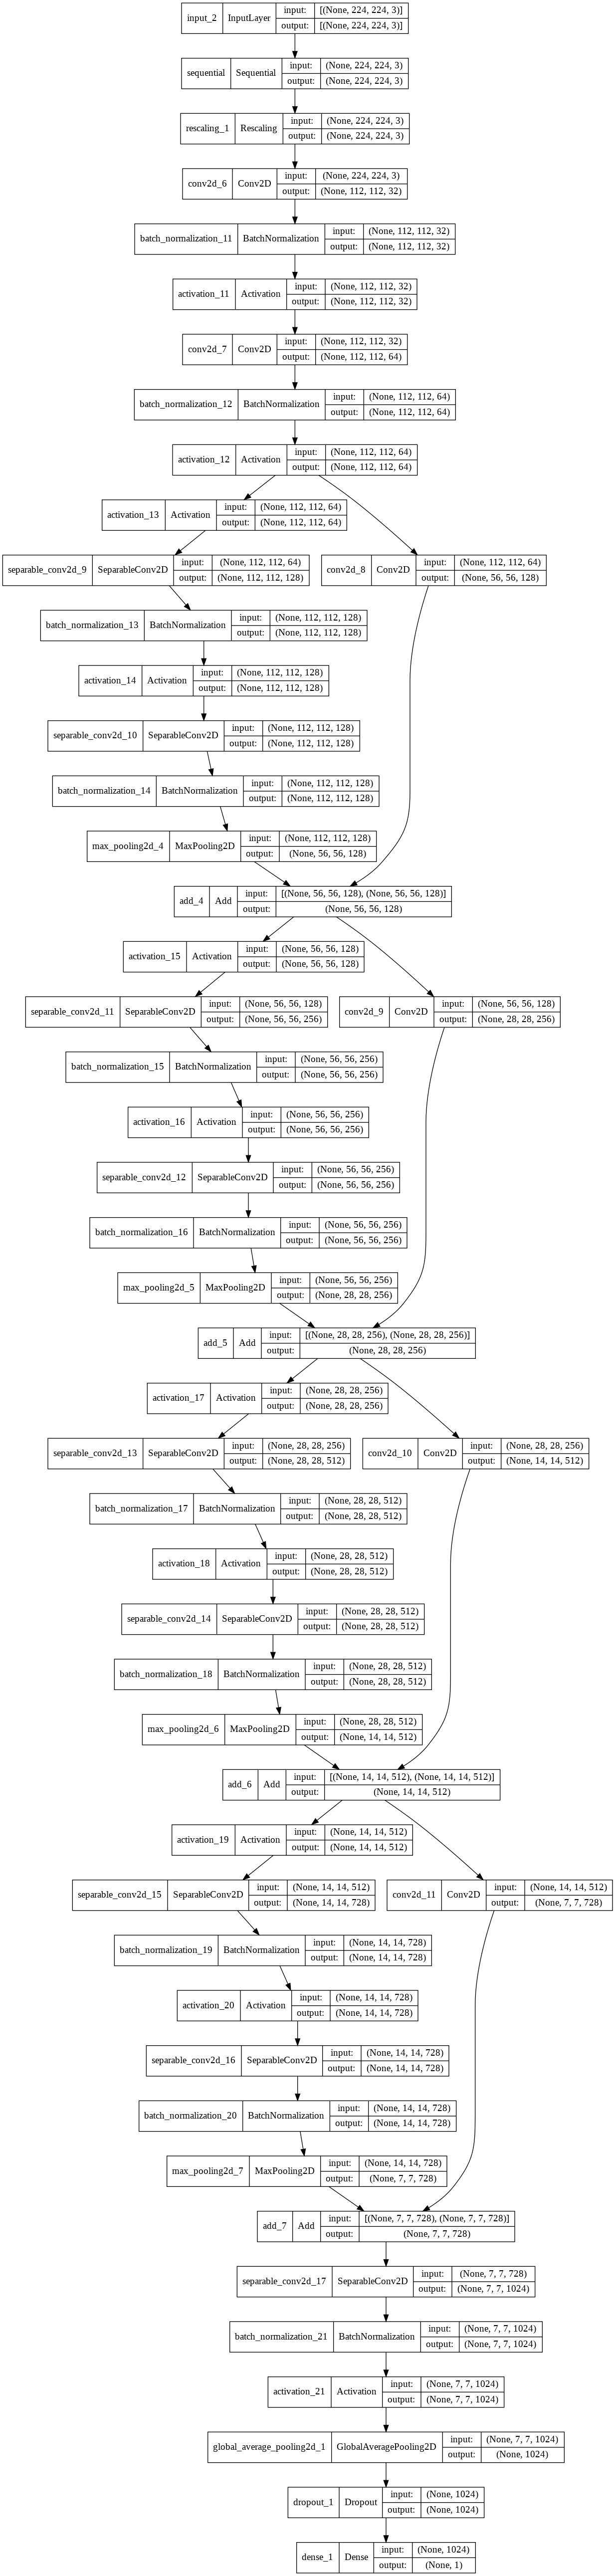

In [ ]:
keras.utils.plot_model(model, show_shapes=True)


### Xception with Original Data Size of 225
Run the next cell.
Assume that the current dataset is still same as above without any changes

#### Test Results

In [ ]:
CNN_model = CNN(input_shape=image_size + (3,), num_classes=2)

CNN_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
CNN_model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/20
586/586 [==============================] - 166s 279ms/step - loss: 0.6390 - accuracy: 0.6480 - val_loss: 0.5609 - val_accuracy: 0.7114
Epoch 2/20
586/586 [==============================] - 163s 278ms/step - loss: 0.5060 - accuracy: 0.7560 - val_loss: 0.5041 - val_accuracy: 0.7770
Epoch 3/20
586/586 [==============================] - 163s 278ms/step - loss: 0.4152 - accuracy: 0.8162 - val_loss: 0.3270 - val_accuracy: 0.8569
Epoch 4/20
586/586 [==============================] - 163s 279ms/step - loss: 0.3294 - accuracy: 0.8606 - val_loss: 0.4078 - val_accuracy: 0.8048
Epoch 5/20
586/586 [==============================] - 163s 279ms/step - loss: 0.2887 - accuracy: 0.8801 - val_loss: 0.9787 - val_accuracy: 0.6153
Epoch 6/20
586/586 [==============================] - 163s 278ms/step - loss: 0.2388 - accuracy: 0.8993 - val_loss: 0.6272 - val_accuracy: 0.7770
Epoch 7/20
586/586 [==============================] - 163s 278ms/step - loss: 0.2183 - accuracy: 0.9100 - val_loss: 0.1862 -

##### Negative Results for Edge Cases


In [ ]:
"""
Wrong_cat and wrong dogs array will contain img is missclassify by more than 70%
"""
wrong_cats = []
wrong_cats_label = []
wrong_dogs = []
wrong_dogs_label = []
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        img = keras.preprocessing.image.load_img(fpath, target_size=image_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis

        predictions = CNN_model.predict(img_array)
        score = predictions[0]
        if folder_name == "Cat" and score > .7:
          wrong_cats.append(img)
          wrong_cats_label.append(((1-score[0])*100))
        elif folder_name == "Dog" and score < .3:
          wrong_dogs.append(img)
          wrong_dogs_label.append(score[0]*100)



##### Edge Cases for Cats

In [ ]:
edge_cats = []
edge_cats_label =[]
edge_dogs = []
edge_dogs_label = []
cat_edge_score = .5
dog_edge_score = 25
for i in range(len(wrong_cats_label)):
  if float(wrong_cats_label[i]) < cat_edge_score:
    edge_cats.append(wrong_cats[i])
    edge_cats_label.append(wrong_cats_label[i])

for i in range(len(wrong_dogs_label)):
  if float(wrong_dogs_label[i]) < dog_edge_score:
    edge_dogs.append(wrong_dogs[i])
    edge_dogs_label.append(wrong_dogs_label[i])

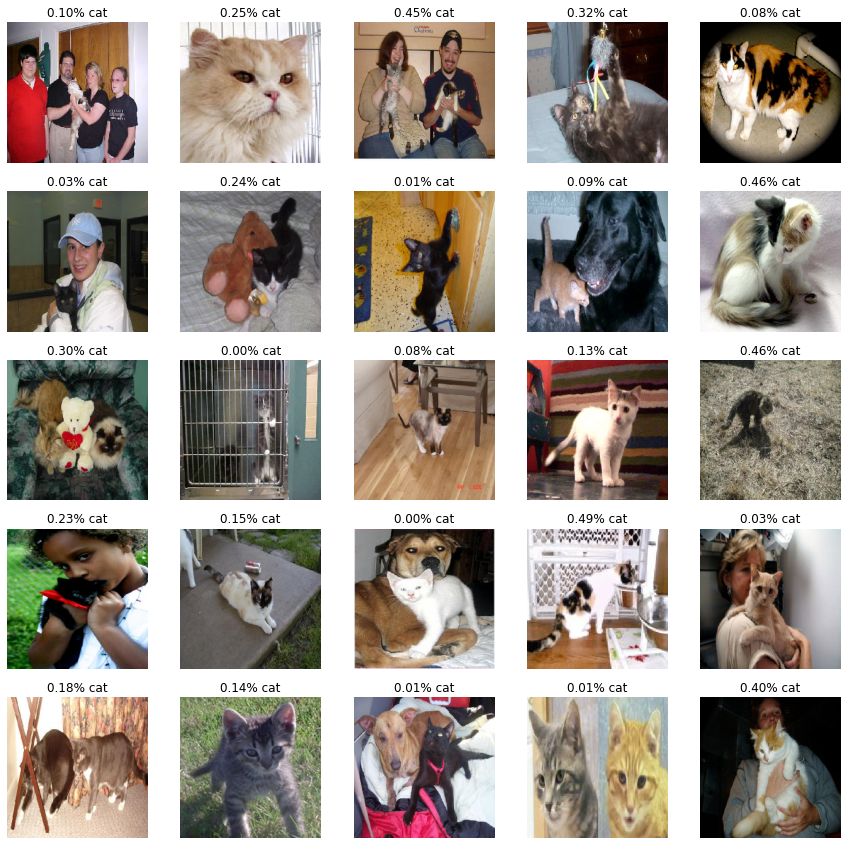

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(min(len(edge_cats_label),25)):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(edge_cats[i])
  plt.axis("off")
  plt.title("%.2f%% cat"%(edge_cats_label[i]))
plt.show()

##### Edge Cases for Dogs

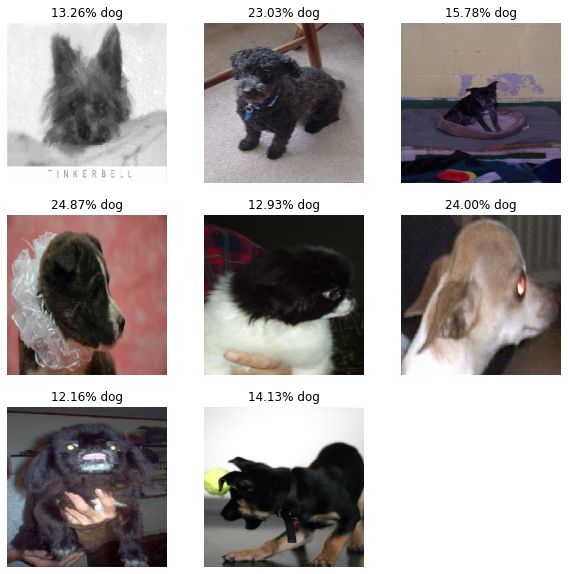

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(min(len(edge_dogs_label),9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(edge_dogs[i])
  plt.axis("off")
  plt.title("%.2f%% dog"%(edge_dogs_label[i]))
plt.show()

#### Edge Case Explanation
There were four main obstacles that made image classification difficult:
- Illumination
- Deformation
- Occlusion
- Intraclass variation

Illumination: it is much easier for human eyes to identify objects in a slighty dimmer environment. Most of the time, it is difficult for humans to classify objects that are very dark or very bright. 
As we see in the top right corner of the dog, the lighting is slighty dimmed, in addition to the dark coat of the bull dog, despite having a bright color background to constrast the object. The machine may only be able to read a block of black pixels and would be unable to extract features.

Deformation: animals can be in different positions and poses. In the middle row of dog examples, the image only captures the left side of the dog. Unlike other training data, where we will mostly see the front and whole body of the dog, the pattern of the pixels has more error compare to other images. We also see a similar problem with the cat images when the cat is standing up or laying on the ground. 

Occlusion: sometimes an animal in an image is not fully presented, some part of the animal may be hidden. Also, sometimes the natural color of the object is similar to the background. All of these reasons can cause the algorithm to be unable to extract features or to misidentify the object. For example, the algorithm will identify a cat with a similar color to the ground on its right side as only 0.46% likely to be a cat.

Intraclass variation: often times, the image contains more than just a single cat, it contains other animals as well. For example, there are many cat images that are misclassified when the cat is on a chair with other dolls, when a human is holding up the cat, or when a dog is also in the image. 

Overall, it is difficult for the algorithm to classify images when the color of the object blends in with the background, when the object is in a different position or on a different post, when only part of the object is shown, or when multiple different object appear in the same image. 


### Test Reducing the Image Size to 180x180

In [ ]:
image_size = (180, 180)
batch_size = 32

m_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
m_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)



Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


#### Test Result

In [ ]:

CNN_m_model = CNN(input_shape=image_size + (3,), num_classes=2)

CNN_m_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
CNN_m_model.fit(
    m_train_ds, epochs=epochs, validation_data=m_val_ds,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.
Epoch 1/20
586/586 [==============================] - 115s 192ms/step - loss: 0.6378 - accuracy: 0.6578 - val_loss: 0.9989 - val_accuracy: 0.5534
Epoch 2/20
586/586 [==============================] - 112s 190ms/step - loss: 0.4750 - accuracy: 0.7738 - val_loss: 0.8791 - val_accuracy: 0.6672
Epoch 3/20
586/586 [==============================] - 112s 191ms/step - loss: 0.3887 - accuracy: 0.8241 - val_loss: 0.9554 - val_accuracy: 0.6638
Epoch 4/20
586/586 [==============================] - 112s 191ms/step - loss: 0.3338 - accuracy: 0.8560 - val_loss: 0.2880 - val_accuracy: 0.8755
Epoch 5/20
586/586 [==============================] - 112s 190ms/step - loss: 0.2930 - accuracy: 0.8753 - val_loss: 0.4527 - val_accuracy: 0.7832
Epoch 6/20
586/586 [==============================] - 112s 190ms/step - loss: 0.2388 - accuracy: 0.8996 - val_loss: 0.205

### Test Reducing the Image Size to 90x90

In [ ]:
image_size = (90 , 90)
batch_size = 32

s_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
s_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


#### Test Result

In [ ]:
CNN_s_model = CNN(input_shape=image_size + (3,), num_classes=2)

CNN_s_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
CNN_s_model.fit(
    s_train_ds, epochs=epochs, validation_data=s_val_ds,
)

Epoch 1/20
586/586 [==============================] - 41s 54ms/step - loss: 0.5979 - accuracy: 0.6902 - val_loss: 0.8126 - val_accuracy: 0.5628
Epoch 2/20
586/586 [==============================] - 31s 53ms/step - loss: 0.4610 - accuracy: 0.7829 - val_loss: 0.4069 - val_accuracy: 0.8135
Epoch 3/20
586/586 [==============================] - 31s 53ms/step - loss: 0.3946 - accuracy: 0.8213 - val_loss: 0.4982 - val_accuracy: 0.7687
Epoch 4/20
586/586 [==============================] - 31s 53ms/step - loss: 0.3509 - accuracy: 0.8418 - val_loss: 0.6518 - val_accuracy: 0.7614
Epoch 5/20
586/586 [==============================] - 31s 53ms/step - loss: 0.3209 - accuracy: 0.8621 - val_loss: 0.5466 - val_accuracy: 0.7785
Epoch 6/20
586/586 [==============================] - 31s 53ms/step - loss: 0.2929 - accuracy: 0.8744 - val_loss: 0.2821 - val_accuracy: 0.8806
Epoch 7/20
586/586 [==============================] - 31s 53ms/step - loss: 0.2694 - accuracy: 0.8849 - val_loss: 0.3267 - val_accuracy:

### Result of Reducing the Image Size
<p>We saw that when we first reduced the size of the image from 225x225 pixels to 180x180, the accuracy only changed by about 0.7%, from 96.20% to 95.64%. This indicates that the model can still retrieve enough information  with 180x180 pixels to classify cats and dogs, even though it is given less input about the image. When the image size was reduced to 90x90, a quarter of the prior image size, the accuracy reduced to 93.17%. In this case, reducing the image by a quarter decreased the accuracy by about 2%. This is likely caused by the increased difficulty of identifying patterns across the images when they are blurred. As image quality reduces, even humans can have difficulty discerning the features that would differentiate a cat and a dog.</p>

<p>On the other hand, reducing the size of the image increased the model's speed by significantly decreasing the size of the input dataset. </p>

<p>There is a sweet spot that can be achieved where the model runs at a reasonable speed while achieving sufficient accuracy. We found this to be at an image size of 180x180. It is well over our goal accuracy of 80%. For this reason, we will continue with this image size below.</p>

### CNN Without Batch Normalization

In [ ]:
def CNN_No_BN(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)
    
    #Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

#### Adjust Image to size 180

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

##### Test Result

In [ ]:
CNN_nob_model = CNN_No_BN(input_shape=image_size + (3,), num_classes=2)

CNN_nob_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
CNN_nob_model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.
Epoch 1/20
586/586 [==============================] - 106s 177ms/step - loss: 0.6938 - accuracy: 0.5068 - val_loss: 0.6895 - val_accuracy: 0.5651
Epoch 2/20
586/586 [==============================] - 103s 176ms/step - loss: 0.6909 - accuracy: 0.5296 - val_loss: 0.6866 - val_accuracy: 0.5528
Epoch 3/20
586/586 [==============================] - 103s 176ms/step - loss: 0.6841 - accuracy: 0.5541 - val_loss: 0.6746 - val_accuracy: 0.5874
Epoch 4/20
586/586 [==============================] - 103s 176ms/step - loss: 0.6806 - accuracy: 0.5690 - val_loss: 0.6799 - val_accuracy: 0.5485
Epoch 5/20
586/586 [==============================] - 103s 176ms/step - loss: 0.6782 - accuracy: 0.5728 - val_loss: 0.6583 - val_accuracy: 0.6079
Epoch 6/20
586/586 [==============================] - 103s 176ms/step - loss: 0.6637 - accuracy: 0.5950 - val_loss: 0.655

### CNN Results

Based on our initial goal of achieving 80% accuracy, the Convolutional Neural Network performed well by achieving an accuracy of 96%.

As shown by the final run of the model, using batch normalization contributed to the high accuracy of the model. Without batch normalization and using an image size of 180x180, the model achieved an accuracy of 85%, but with batch normalization, it achieved an accuracy of 96%. This shows a significant contribution to the success of the model.

# Comparing Model Results

Given its ability to group data from several pixels together at once, the Convolutional Neural Network has the opportunity to identify features of each animal and recognize them in other images. For example, an animal's nose or ear shape may be easy identifiers. 

Meanwhile, Logistic Regression cannot take into account groups of pixels. It processes each pixel of an image at nearly equal importance. The features it can pick up on are the similarities in color values at certain pixels throughout the image. Based on our initial goal of achieving 80% accuracy, this method produced an insufficient model for classifying the images. While Logistic Regression can work well across some datasets, it was not a good option for modeling an image dataset.

Thus, a CNN was significantly better than logistic regression at classifying whether an image contained a cat or dog.


# Future Work

<p> Given more time, additional classification models could have been compared against the two shown above. Multi-label classification could be considered a valuable feature for a model of this type. For example, several of the edge case images showed multiple animals within one image. Using multi-label classification, all of the animals in an image could be purposefully identified. </p>
<p>In addition, variation in the types of input could have affected the accuracy of the models. For example, cartoon images of cats and dogs could be added to the dataset. </p>

# Sources
https://cs231n.github.io/convolutional-networks/

https://arxiv.org/abs/1610.02357

https://arxiv.org/abs/1502.03167

https://arxiv.org/abs/1409.1556

https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/

https://www.mathworks.com/help/deeplearning/ref/xception.html

https://keras.io/examples/vision/image_classification_from_scratch/

https://arxiv.org/abs/1610.02357

In [8]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/Cats-and-Dogs-Classification/CS6140 Image Classification By Brittnee Braun and Felix Chung.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Cats-and-Dogs-Classification/CS6140 Image Classification By Brittnee Braun and Felix Chung.ipynb to PDF
[NbConvertApp] Support files will be in CS6140 Image Classification By Brittnee Braun and Felix Chung_files/
[NbConvertApp] Making directory ./CS6140 Image Classification By Brittnee Braun and Felix Chung_files
[NbConvertApp] Making directory ./CS6140 Image Classification By Brittnee Braun and Felix Chung_files
[NbConvertApp] Making directory ./CS6140 Image Classification By Brittnee Braun and Felix Chung_files
[NbConvertApp] Making directory ./CS6140 Image Classification By Brittnee Braun and Felix Chung_files
[NbConvertApp] Making directory ./CS6140 Image Classification By Brittnee Braun and Felix Chung_files
[NbConvertApp] Making directory ./CS6140 Image Classification By Brittnee Braun and Felix Chung_files
[NbConvertApp] Making directory ./CS6140 Image Classification By Brittnee Braun and Felix Chung_files